In [1]:
from sknn.mlp import Regressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib
import sklearn
from sknn.mlp import Regressor, Layer
from sklearn_pandas import DataFrameMapper
matplotlib.style.use('ggplot')
%matplotlib inline

/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [109]:
df = pd.read_csv('india_surroundings_1mar2016 _28_feb_2017.csv')
del df['IRIS ID'], df['Year'], df['Month'], df['Day'], df['Time UTC'], df['Region']
df = df.iloc[::-1]
#df = pd.get_dummies(df)

In [110]:
train_test_ratio = .7
train_size = int(df.shape[0] * train_test_ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
df.head()

     Mag    Lat    Lon  Depth km   Timestamp
279  4.6  29.75  69.93      10.0  1456900511
278  4.0  35.53  70.24      89.5  1457132148
277  4.2  36.49  71.10     101.3  1457232360
276  4.6  20.98  95.02     101.0  1457320438
275  4.5  22.76  93.94      50.0  1457353381

In [111]:
mapper = DataFrameMapper([
       # (['Region'], None),
        (['Mag'],sklearn.preprocessing.StandardScaler()),
        (['Lat'],sklearn.preprocessing.StandardScaler()),
        (['Lon'],sklearn.preprocessing.StandardScaler()),
        (['Depth km'],sklearn.preprocessing.StandardScaler()),
        (['Timestamp'], sklearn.preprocessing.StandardScaler()) 
    ],default = None)
train_data = mapper.fit_transform(train_data)
#train_data[['Mag','Lat','Lon','Timestamp','Depth km']] = train_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)
test_data = mapper.transform(test_data)
#test_data[['Mag','Lat','Lon','Timestamp','Depth km']] = test_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)


/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [112]:
past = 14  # number of past earthquakes to consider
def getXandY(data):
    X, Y = [], []
    for i in range(data.shape[0]-past):
        X += [data[i:i+past].flatten()]
        Y += [data[i+past]]
    return X, Y
train_X, train_Y = getXandY(train_data)
test_X, test_Y = getXandY(test_data)
train_X, train_Y, test_X, test_Y = np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)
print(np.shape(train_X), np.shape(train_Y))
print(np.shape(test_X), np.shape(test_Y))

(182, 70) (182, 5)
(70, 70) (70, 5)


In [113]:
nn = Regressor(
    layers=[
         Layer("Tanh",units= 60),
        Layer("Tanh",units = 60),
        Layer("Linear")],
    learning_rate=0.001,
    dropout_rate=.3,
    learning_rule=u'rmsprop',
    n_iter= 1000) 

In [118]:
gs = GridSearchCV(nn, param_grid={
    'hidden0__units': [20, 40, 60, 80],
    'hidden0__type': ["Sigmoid", "Rectifier", "Tanh"],
    'hidden1__units': [20, 40, 60],
    'hidden1__type': ["Sigmoid", "Rectifier", "Tanh"],
    'learning_rule': ['rmsprop','adam']
}) 
import warnings 
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    gs.fit(train_X, train_Y)
print(gs.best_params_)

{'hidden1__units': 60, 'learning_rule': 'rmsprop', 'hidden0__units': 20, 'hidden1__type': 'Tanh', 'hidden0__type': 'Tanh'}


In [121]:
bp = gs.best_params_
errors = []
def store_stats(avg_valid_error, avg_train_error, **_):
    errors.append(avg_train_error) 

nn = Regressor(
    layers=[
        Layer(bp['hidden0__type'],units= bp['hidden0__units']),
        Layer(bp['hidden1__type'],units = bp['hidden1__units']),
        Layer("Linear")],
    callback={'on_epoch_finish': store_stats},
    learning_rate=0.001,
    dropout_rate=.3,
    learning_rule=bp['learning_rule'],
    n_iter= 100) 

In [122]:
nn.fit(train_X, train_Y) 
# see what is giving best score here
nn.score(test_X, test_Y)

-0.47056545796715354

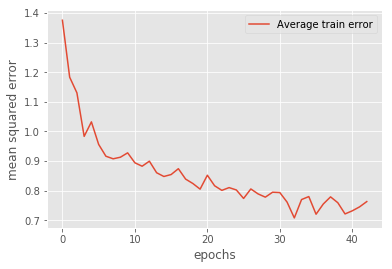

In [123]:
plt.plot(errors,label='Average train error')
plt.ylabel('mean squared error')
plt.xlabel('epochs')
plt.legend()
plt.savefig("ffnm1.eps", format="eps") 
plt.show()

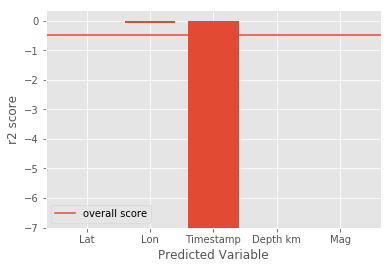

total r2 score -0.470565457967
r2 scores for individual variables {'Lat': -0.014999999999999999, 'Lon': -0.071999999999999995, 'Timestamp': -7.0069999999999997, 'Depth km': -0.001, 'Mag': -0.0040000000000000001}


/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


In [124]:
test_outputs = nn.predict(test_X)
test_targets = test_Y
test_targets, test_outputs = np.reshape(test_targets,(-1,5)), np.reshape(test_outputs,(-1,5)) 
from sklearn.metrics import r2_score
total_error = r2_score(test_targets, test_outputs) 
print("total r2 score", total_error)
plt.axhline([total_error],0,1,label='overall score')
indv_error_dict = {col:np.round(r2_score(test_targets[:,i], test_outputs[:,i]),3) for i, col in enumerate(df.columns)}
print("r2 scores for individual variables", indv_error_dict)
plt.bar(range(len(indv_error_dict)), indv_error_dict.values())
plt.xticks(range(len(indv_error_dict)), indv_error_dict.keys())
plt.ylabel('r2 score')
plt.xlabel('Predicted Variable')
plt.legend()
plt.savefig("ffnm2.eps", format="eps")
plt.show()